# Load data and word embeddings

In [21]:
import pickle
import numpy as np
from tqdm.notebook import tqdm

In [22]:
dset = pickle.load(open('data/dataset.pkl', 'rb'))
emb = pickle.load(open('data/glove.100.emb', 'rb'))
t2i, i2t, s2i, i2s, in2i, i2in = dset['t2i'], dset['i2t'], dset['s2i'], dset['i2s'], dset['in2i'], dset['i2in']
query_train, slot_train, intent_train = dset['query_train'], dset['slot_train'], dset['intent_train']
query_dev, slot_dev, intent_dev = dset['query_dev'], dset['slot_dev'], dset['intent_dev']
query_test, slot_test, intent_test = dset['query_test'], dset['slot_test'], dset['intent_test']

In [23]:
print("Vocabulary size in dataset: {}".format(len(t2i)))
print("Number of sentense class in dataset: {}".format(len(in2i)))
print("Number of token class in dataset: {}".format(len(s2i)))
print("Word embedding shape VxD: {}".format(emb.shape))

Vocabulary size in dataset: 943
Number of sentense class in dataset: 26
Number of token class in dataset: 129
Word embedding shape VxD: (943, 100)


In [24]:
def print_sample(i, query, slot):
    print([i2t[k] for k in query[i]], i2in[intent_train[i][0]])
    print([i2s[k] for k in slot[i]],  i2in[intent_train[i][0]])

In [25]:
print_sample(1, query_train, slot_train)

['bos', 'please', 'list', 'information', 'regarding', 'san', 'francisco', 'airport', 'eos'] airport
['o', 'o', 'o', 'o', 'o', 'b-airport_name', 'i-airport_name', 'i-airport_name', 'o'] airport


In [26]:
print_sample(2, query_train, slot_train)

['bos', 'show', 'me', 'the', 'flights', 'from', 'oakland', 'to', 'denver', 'eos'] flight
['o', 'o', 'o', 'o', 'o', 'o', 'b-fromloc.city_name', 'o', 'b-toloc.city_name', 'o'] flight


In [27]:
print_sample(3, query_train, slot_train)

['bos', 'how', 'many', 'fare', 'codes', 'belong', 'to', 'economy', 'class', 'eos'] quantity
['o', 'o', 'o', 'o', 'o', 'o', 'o', 'b-economy', 'i-economy', 'o'] quantity


# Pad datasets! query and slot

We use an additional symbol "pad", pad the sentences and query to have same lengths, and record their original length

In [28]:
from utils import pad_dataset

# add <pad> into the vocabulary
i2t[len(i2t)] = '<pad>'
t2i['<pad>'] = len(i2t) - 1
emb_padded = np.append(emb, np.zeros((1, 100)), axis=0)

seq_max_len = 30
query_train_padded, train_lengths = pad_dataset(query_train, seq_max_len, t2i['<pad>'])
query_dev_padded, dev_lengths = pad_dataset(query_dev, seq_max_len, t2i['<pad>'])
query_test_padded, test_lengths = pad_dataset(query_test, seq_max_len, t2i['<pad>'])
slot_train_padded, _ = pad_dataset(slot_train, seq_max_len, s2i['o'])
slot_dev_padded, _ = pad_dataset(slot_dev, seq_max_len, s2i['o'])
slot_test_padded, _ = pad_dataset(slot_test, seq_max_len, s2i['o'])

In [29]:
print("original lengths", [len(query_train[i]) for i in range(10)])
print("padded lengths", [len(query_train_padded[i]) for i in range(10)])
print("example padded query: ")
print_sample(2, query_train_padded, slot_train_padded)

original lengths [11, 9, 10, 10, 10, 13, 11, 8, 11, 25]
padded lengths [30, 30, 30, 30, 30, 30, 30, 30, 30, 30]
example padded query: 
['bos', 'show', 'me', 'the', 'flights', 'from', 'oakland', 'to', 'denver', 'eos', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>'] flight
['o', 'o', 'o', 'o', 'o', 'o', 'b-fromloc.city_name', 'o', 'b-toloc.city_name', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o'] flight


# dataset and dataloader for slot filling and intent classification

In [30]:
config = {
    'bz': 100, # batch size
    'rnn': 'LSTM',
    'bidirection': True,
    'rnn_hidden_dim': 100,
    'epoch': 15,
}

In [31]:
from torch.utils.data import DataLoader, Dataset

In [32]:
class IntentBatchDataset(Dataset):

    def __init__(self, query, lengths, intent):
        self.dataset = query
        self.intent = intent
        self.lengths = lengths

    def __getitem__(self, idx):

        return {
            'x': np.array(self.dataset[idx], dtype=np.int32),
            'in': np.array(self.intent[idx], dtype=np.int32),
            'l': np.array(self.lengths[idx], dtype=np.int32),
        }

    def __len__(self):
        return len(self.dataset)

In [33]:
intent_dataset_train = IntentBatchDataset(query_train_padded, train_lengths, intent_train)
intent_dataset_dev = IntentBatchDataset(query_dev_padded, dev_lengths, intent_dev)
intent_dataset_test = IntentBatchDataset(query_test_padded, test_lengths, intent_test)

In [34]:
bz = config['bz']
intent_dataloader_train = DataLoader(intent_dataset_train, batch_size=bz)
intent_dataloader_dev = DataLoader(intent_dataset_dev, batch_size=bz)
intent_dataloader_test = DataLoader(intent_dataset_test, batch_size=bz)

# Model for intent classification

In [35]:
import torch
from torch import nn
from torch.nn.utils.rnn import pad_packed_sequence, pack_padded_sequence

class IntentNeuralSoftmax(nn.Module):
    def __init__(self, pretrained_embed, intent_size, config):
        super(IntentNeuralSoftmax, self).__init__()

        self.bidirection = config['bidirection']
        self.directions = 2 if self.bidirection else 1
        self.is_cuda = torch.cuda.is_available()
        self.V, self.D = pretrained_embed.shape
        self.rnn_type = config['rnn']
        self.rnn_hidden_dim = config['rnn_hidden_dim'] // 2 if \
            self.bidirection else config['rnn_hidden_dim'] 

        self.intent_size = intent_size

        self.loss = nn.CrossEntropyLoss()

        if self.rnn_type == 'RNN':
            self.rnn = nn.RNN(input_size=self.D,
                              hidden_size=self.rnn_hidden_dim,
                              num_layers=1,
                              batch_first=True,
                              bidirectional=self.bidirection,
                              bias=False)

        elif self.rnn_type == 'LSTM':
            self.rnn = nn.LSTM(input_size=self.D,
                               hidden_size=self.rnn_hidden_dim,
                               num_layers=1,
                               batch_first=True,
                               bidirectional=self.bidirection,
                               bias=False)

        self.embedding = nn.Embedding.from_pretrained(torch.from_numpy(pretrained_embed).float(),
                                                      freeze=True)  # V x D

        self.linear_intent = nn.Linear(self.rnn_hidden_dim*self.directions, self.intent_size)

    def forward(self, input, label_intent, lengths):
        input = self.embedding(input)  # B x L x D
        pack_padded_seq_input = pack_padded_sequence(input, lengths.cpu(), batch_first=True, enforce_sorted=False)

        B, L, D = input.size()

        if self.rnn_type in ['RNN']:
            output_packed, hn = self.rnn(pack_padded_seq_input)  # B x L x H
        elif self.rnn_type == 'LSTM':
            output_packed, (hn, cn) = self.rnn(pack_padded_seq_input)  # B x L x H

        output_padded, output_lengths = pad_packed_sequence(output_packed, batch_first=True)

        # intent classification
        last_hidden = output_padded[torch.arange(B), output_lengths-1, :]
        score_intent = self.linear_intent(last_hidden)

        loss_intent, pred_labels_intent = \
            self.calculate_intent_loss(score_intent, label_intent)

        return loss_intent, pred_labels_intent

    def calculate_intent_loss(self, scores_intent, label_intent):
        loss = self.loss(scores_intent, label_intent.squeeze())
        max_score_intent, pred_labels_intent = scores_intent.max(dim=1)
        return loss, pred_labels_intent


# funciton: validate, train and metrics

In [36]:
from utils import eval_acc

def val(data, model):
    all_pred_intent_label = []
    all_true_intent_label = []
    all_lengths = []
    model.eval()
    with torch.no_grad():

        for batch in data:

            x = batch['x'].long()
            label_intent = batch['in'].long()
            lengths = batch['l'].long()

            loss_intent, pred_intent_label = model(x, label_intent, lengths)

            all_pred_intent_label += list(pred_intent_label.cpu())
            all_true_intent_label += list(label_intent.cpu())
            all_lengths += list(lengths.cpu())

    acc_intent = eval_acc(
        sent_pred=all_pred_intent_label, sent_true=all_true_intent_label)

    model.train()
    return acc_intent

def train(data, model, optimizer):
    all_pred_intent_label = []
    all_true_intent_label = []
    all_lengths = []
    
    for batch in data:
        
        optimizer.zero_grad()

        x = batch['x'].long()
        label_intent = batch['in'].long()
        lengths = batch['l'].long()

        loss_intent, pred_intent_label = model(x, label_intent, lengths)
        loss_intent.backward()
        optimizer.step()

        all_pred_intent_label += list(pred_intent_label.cpu())
        all_true_intent_label += list(label_intent.cpu())
        all_lengths += list(lengths.cpu())

    acc_intent = eval_acc(
        sent_pred=all_pred_intent_label, sent_true=all_true_intent_label)

    return acc_intent

# init model and optimizer

In [37]:
# for padding
model = IntentNeuralSoftmax(pretrained_embed=emb_padded,
                           intent_size=len(in2i),
                           config=config)

pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('ALL TRAINABLE PARAMETERS: {}'.format(pytorch_total_params))

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0)
print(model)

ALL TRAINABLE PARAMETERS: 62626
IntentNeuralSoftmax(
  (loss): CrossEntropyLoss()
  (rnn): LSTM(100, 50, bias=False, batch_first=True, bidirectional=True)
  (embedding): Embedding(944, 100)
  (linear_intent): Linear(in_features=100, out_features=26, bias=True)
)


# train and evaluation, do not use test for hyper-params tuning

In [38]:
from copy import deepcopy
train_acc_list = []
dev_acc_list = []
test_acc_list = [] # just for visualization

best_dev_acc = -1
best_model = model

for i in range(config['epoch']):
    
    train_acc = train(data=intent_dataloader_train, model=model, optimizer=optimizer)
    dev_acc = val(data=intent_dataloader_dev, model=model)
    test_acc = val(data=intent_dataloader_test, model=model)
    
    if dev_acc > best_dev_acc:
        best_dev_acc = dev_acc
        best_model = deepcopy(model)
    
    print('epoch: {}, train_acc: {}, dev_acc: {}: test_acc: {}'.
          format(i+1, train_acc, dev_acc, test_acc))
    train_acc_list.append(train_acc)
    dev_acc_list.append(dev_acc)
    test_acc_list.append(test_acc)
    
    
print('final test acc: {}'.format(val(data=intent_dataloader_test, model=best_model)))

epoch: 1, train_acc: 0.6870919136112507, dev_acc: 0.7439759036144579: test_acc: 0.7077267637178052
epoch: 2, train_acc: 0.7345554997488699, dev_acc: 0.7439759036144579: test_acc: 0.7077267637178052
epoch: 3, train_acc: 0.7378201908588649, dev_acc: 0.7580321285140562: test_acc: 0.7323628219484882
epoch: 4, train_acc: 0.784028126569563, dev_acc: 0.8654618473895582: test_acc: 0.8051511758118701
epoch: 5, train_acc: 0.8679055750878956, dev_acc: 0.8865461847389559: test_acc: 0.8219484882418813
epoch: 6, train_acc: 0.8812154696132597, dev_acc: 0.893574297188755: test_acc: 0.8241881298992161
epoch: 7, train_acc: 0.8937719738824711, dev_acc: 0.9166666666666666: test_acc: 0.8365061590145577
epoch: 8, train_acc: 0.9090909090909091, dev_acc: 0.9176706827309237: test_acc: 0.8555431131019037
epoch: 9, train_acc: 0.9156202913108991, dev_acc: 0.9257028112449799: test_acc: 0.8633818589025756
epoch: 10, train_acc: 0.9224008036162732, dev_acc: 0.928714859437751: test_acc: 0.8756998880179171
epoch: 11, t

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'accuracy curves')

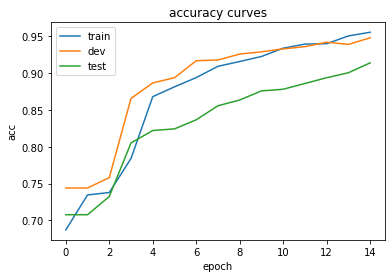

In [40]:
plt.plot(train_acc_list, label='train')
plt.plot(dev_acc_list, label='dev')
plt.plot(test_acc_list, label='test')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.title('accuracy curves')